In [4]:
# lib that need
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
import scipy.io as sio
from torch.autograd import Variable
from tqdm import tqdm

from PIL import Image

from torch.utils.data import Dataset, DataLoader

# says it can accelerate the model
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# data preprocess  -> 224X224 like resnet paper use
transform = transforms.Compose(
    [transforms.Resize(1024),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])]
)

class MyDataset(Dataset):
    def __init__(self,root,transform=None):
        super(MyDataset,self).__init__()
        self.root = root
        self.img_list = os.listdir(root)
        self.transform = transform

    def __getitem__(self,index):
        img_name = os.path.join(self.root,self.img_list[index])
        if self.img_list[index][0] == 'h':
            label = 1
        else:
            label = 0
        img = Image.open(img_name)
        # img_tensor = transforms.ToTensor(img)
        if self.transform is not None:
            img = self.transform(img)
        return img,label

    def __len__(self):
        return len(self.img_list)

# dataset and dataloader
train_set = MyDataset(root='/content/drive/My Drive/QML/cv/image_classification/train set',transform=transform)
test_set = MyDataset(root='/content/drive/My Drive/QML/cv/image_classification/test set',transform=transform)

batch_size = 10

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers=4)

# for (inputs, labels) in train_loader:
#     print(inputs.shape)
#     print(labels)



# flatten the output to  full-connection
def flatten(x):
    N = x.shape[0]  # x -> N,C,H,W
    return x.view(N,-1)
class Flatten(nn.Module):
    def forward(self,x):
        return flatten(x)

# classical convolution network
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),  # reduce memory
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(x_conv1)
        # x_conv2 = x_conv2.view(-1, 16 * 5 * 5)
        x_fc = self.fc(x_conv2)
        return x_fc

# residual block
class Bottleneck(nn.Module):
    def __init__(self, in_channels, stride=1, first_layer=False,down_sampling=False,next_layer=False,groups=1,depth=1):
        """

        :param in_channels: in_channels
        :param stride:stride of 3x3 conv
        :param first_layer:conv with no down_sampling
        :param down_sampling:down_sampling
        :param next_layer:different block of conv
        :param groups:3x3 conv groups
        :param depth:residual block depth
        """
        super(Bottleneck, self).__init__()
        change_channels = 4*in_channels
        self.downsampling = down_sampling
        self.first_layer = first_layer

        base_channels = 64      # base-channels
        if groups == 1:         # resnet
            width_channels = in_channels
            down_sampling_channels = 2*in_channels
        elif groups == 32:      # resnext
            width_channels = np.int(in_channels/base_channels)*depth*groups
            down_sampling_channels = width_channels
        if first_layer:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels,width_channels , kernel_size=1),
                nn.BatchNorm2d(width_channels),
                nn.ReLU(inplace=True)   # in_place to reduce memory
            )
        elif next_layer:
            self.conv1 = nn.Sequential(
                nn.Conv2d(down_sampling_channels, width_channels, kernel_size=1),
                nn.BatchNorm2d(width_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(change_channels, width_channels, kernel_size=1),  # the last layer of residual block in the conv block
                nn.BatchNorm2d(width_channels),                                 #                -> the first layer of next residual block
                nn.ReLU(inplace=True)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(width_channels,width_channels,kernel_size=3,stride=stride,padding=1,groups=groups),
            nn.BatchNorm2d(width_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
                nn.Conv2d(width_channels,change_channels,kernel_size=1),   # change_channels are input_channels->1X1 conv2_nums
                nn.BatchNorm2d(change_channels)
            )
        if self.downsampling:   # if down_sampling  define layer stride = 2
            self.downsampling_layer = nn.Sequential(
                nn.Conv2d(down_sampling_channels,change_channels,1,stride=2),
                nn.BatchNorm2d(change_channels)
            )
        # conv2 first add 1x1_conv to let dim same
        if first_layer:
            self.downsampling_layer = nn.Sequential(
                nn.Conv2d(in_channels,change_channels,1,stride=1),
                nn.BatchNorm2d(change_channels)
            )
    def forward(self,x):
        identity = x
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(x_conv1)
        x_conv3 = self.conv3(x_conv2)
        if self.downsampling or self.first_layer:   # if down_sampling x should go through down_sampling layer(1x1 conv ) to let dim same
            identity = self.downsampling_layer(x)
        return F.relu(x_conv3+identity)

# conv_block
def resnet_block(in_channels,num_block,down_sampling=False,change=False,groups=1,depth=1):
    """

    :param in_channels: in_channels
    :param num_block: num of block
    :param down_sampling: down_sampling or not
    :param change:stride from 1->2 residual block 3x3 conv
    :param groups:groups
    :param depth: depth
    :return:
    """
    conv_blk = []
    for i in range(num_block):
        if i == 0 :     # first layer of block
            if change:
                conv_blk.append(Bottleneck(in_channels,first_layer=False,stride=2,down_sampling=down_sampling,next_layer=True,groups=groups,depth=depth))
            else:
                conv_blk.append(
                    Bottleneck(in_channels, first_layer=True, stride=1, down_sampling=down_sampling,groups=groups,depth=depth))     # conv2 block first layer
        else:
            conv_blk.append(Bottleneck(in_channels,first_layer=False,stride=1,down_sampling=False,groups=groups,depth=depth))       # the left layer

    return nn.Sequential(*conv_blk)

class ResNet_50(nn.Module):
    def __init__(self):
        super(ResNet_50, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(3,2,padding=1),
            nn.Sequential(resnet_block(64,3,down_sampling=False))
        )
        self.conv3 = resnet_block(128,4,down_sampling=True,change=True)
        self.conv4 = resnet_block(256,6,down_sampling=True,change=True)
        self.conv5 = resnet_block(512,3,down_sampling=True,change=True)
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),   # global avgerage pool
            Flatten(),
            nn.Linear(512 * 4, 2),
            nn.Softmax(dim=1)
        )
    def forward(self,x):
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(x_conv1)
        x_conv3 = self.conv3(x_conv2)
        x_conv4 = self.conv4(x_conv3)
        x_conv5 = self.conv5(x_conv4)
        output = self.fc(x_conv5)
        return output

resnet_50 = ResNet_50().to(device)
# print(resnet_50)

lr, num_epochs = 0.001, 1000

resnet_50_loss_list = []

resnet_50_acc_list = []
#


# test each conv output shape
def test_net(net):
    net_tn = net
    X = torch.rand((1, 3, 224, 224)).to(device)
    for name, layer in net_tn.named_children():
        X = layer(X)
        print(name, ' output shape:\t', X.shape)
# save net,loss_list and acc_list
def save_model(net,loss_list,acc_list):
    net = net.cpu()
    loss_list_sm = loss_list
    acc_list_sm = acc_list
    sio.savemat('/content/drive/My Drive/QML/cv/image_classification/loss.mat', {'loss': loss_list_sm})
    sio.savemat('/content/drive/My Drive/QML/cv/image_classification/acc.mat', {'acc': acc_list_sm})
    print("model saving...")
    torch.save(net, '/content/drive/My Drive/QML/cv/image_classification/{0}.pth'.format(net.__class__.__name__))

def train_and_test(net,train_loader,test_loader, loss_list,lr,num_epochs,acc_list):

    train_loader = train_loader
    test_loader = test_loader
    net = net.to(device)
    loss_list_ep = loss_list
    lr = lr
    num_epochs = num_epochs
    acc_list_ep = acc_list
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_func = nn.CrossEntropyLoss()

    start_epoch = -1        # checkpoint start_epoch
    # load checkpoint
    model_file = '/content/drive/My Drive/QML/cv/image_classification/checkpoint.pth'
    if os.path.isfile(model_file):
        checkpoint = torch.load(model_file)
        acc_cp = checkpoint['acc']
        start_epoch = checkpoint['epoch']
        net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss_list_ep = checkpoint['loss_list']
        acc_list_cp = checkpoint['acc_list']
        print('Load checkpoint at epoch %d | acc %.2f' % (start_epoch, acc_cp))


    for epoch in range(num_epochs):
        if epoch <= start_epoch:
            continue
        start_time = time.time()
        train_loss = 0.0
        test_acc = 0.0
        train_loss_n = 0
        test_acc_n = 0
        for iter,(inputs, labels) in enumerate(train_loader):     # train

            # inputs = inputs.to(device)
            inputs_img = Variable(inputs).to(device)
            # labels = labels.to(device)
            labels = Variable(labels).to(device)

            labels_predict = net(inputs_img)

            loss = loss_func(labels_predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (iter+1)%5 == 0:
                loss_list_ep.append(loss.item())
                # print('train_loss %.4f '%(loss.item()))
            train_loss += loss.cpu().item()
            train_loss_n += 1

            # del intermediate variables/tensors to reduce memory
            del inputs_img
            del labels
            del labels_predict
            del loss
            # maybe helpful
            torch.cuda.empty_cache()
        train_loss /= train_loss_n
        # print('epoch %d | train_loss %.4f'%(epoch,train_loss))
        loss_list_ep.append(train_loss)

        for inputs, labels in test_loader:        # test
            net.eval()  # test mode to prevent BN influence
            with torch.no_grad():
                inputs_img = Variable(inputs).to(device)
                labels = Variable(labels).to(device)
                labels_predict = net(inputs_img)
                test_acc += torch.sum(labels_predict.cpu().argmax(dim=1) == labels.cpu()).numpy()
                test_acc_n += labels.shape[0]
                # print('test_acc %.2f' % (test_acc / test_acc_n))
            net.train()  # train mode
        test_acc /= test_acc_n
        acc_list_ep.append(test_acc)
        print('epoch %d | train_loss %.4f | test_acc %.2f | time %.2f sec'
              % (epoch, train_loss, test_acc , time.time() - start_time))
        
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',factor=0.1,patience=3,verbose=True)
        # scheduler.step(test_acc)
        # print(optimizer.state_dict()['param_groups'][0]['lr'])

        # save checkpoint
        checkpoint = {
            'acc': test_acc,
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss_list': loss_list_ep,
            'acc_list' : acc_list_ep
        }
        model_file = '/content/drive/My Drive/QML/cv/image_classification/checkpoint.pth'
        torch.save(checkpoint, model_file)
        if test_acc>=0.90:      # reach acc to save model
            save_model(net,loss_list_ep,acc_list_ep)

train_and_test(resnet_50,train_loader,test_loader,resnet_50_loss_list,lr,num_epochs,resnet_50_acc_list)


## cost function figure
# data_loss = sio.loadmat('/content/drive/My Drive/homework/cnn_model/loss.mat')
# loss_list = data_loss['loss']
# # print(loss_list)
# # print(np.nonzero(loss_list))
# loss_plt = []
# print(loss_list.shape[1])
# for i in range(loss_list.shape[1]):
#     if loss_list[0][i] > 0 and (i+1)%1000==0:
#         loss_plt.append(loss_list[0][i])
# list_iter = range(len(loss_plt))
# def draw(num_iter,loss_list):
#     plt.plot(num_iter,loss_list,'-b',label='loss')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.title('loss')
#     plt.savefig('/content/drive/My Drive/homework/cnn_model/loss.eps',format='eps')
# draw(list_iter,loss_plt)



epoch 0 | train_loss 0.6922 | test_acc 0.50 | time 5.81 sec
epoch 1 | train_loss 0.7758 | test_acc 0.50 | time 4.39 sec
epoch 2 | train_loss 0.8038 | test_acc 0.60 | time 4.30 sec
epoch 3 | train_loss 0.7863 | test_acc 0.53 | time 4.33 sec
epoch 4 | train_loss 0.7235 | test_acc 0.57 | time 4.40 sec
epoch 5 | train_loss 0.6775 | test_acc 0.63 | time 4.36 sec
epoch 6 | train_loss 0.6490 | test_acc 0.50 | time 4.32 sec
epoch 7 | train_loss 0.6783 | test_acc 0.57 | time 4.44 sec
epoch 8 | train_loss 0.8776 | test_acc 0.47 | time 4.46 sec
epoch 9 | train_loss 0.9058 | test_acc 0.53 | time 4.37 sec
epoch 10 | train_loss 0.8645 | test_acc 0.40 | time 4.33 sec
epoch 11 | train_loss 0.8825 | test_acc 0.47 | time 4.39 sec
epoch 12 | train_loss 0.8381 | test_acc 0.43 | time 4.42 sec
epoch 13 | train_loss 0.7754 | test_acc 0.53 | time 4.35 sec
epoch 14 | train_loss 0.8527 | test_acc 0.50 | time 4.20 sec
epoch 15 | train_loss 0.8174 | test_acc 0.50 | time 4.30 sec
epoch 16 | train_loss 0.7569 | tes

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ResNet_50. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Bottleneck. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


RuntimeError: ignored

In [15]:

from PIL import Image


img = Image.open(path)
print(img.size)

(640, 480)


In [20]:
import os
import cv2
import numpy as np
path = os.path.join('/content/drive/My Drive/QML/cv/image_classification/train set','1.jpg')
img = cv2.imread(path)
sp = img.shape
print(sp)
sz1 = sp[0]#height(rows) of image
sz2 = sp[1]#width(colums) of image
sz3 = sp[2]#the pixels value is made up of three primary colors
print('width: %d \nheight: %d \nnumber: %d'%(sz1,sz2,sz3))
    


(480, 640, 3)
width: 480 
height: 640 
number: 3


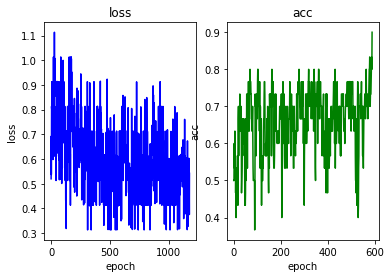

In [13]:
# lib that need
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
import scipy.io as sio
from torch.autograd import Variable
from tqdm import tqdm

from PIL import Image

from torch.utils.data import Dataset, DataLoader

# says it can accelerate the model
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# data preprocess  -> 224X224 like resnet paper use
transform = transforms.Compose(
    [transforms.Resize(1024),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])]
)

class MyDataset(Dataset):
    def __init__(self,root,transform=None):
        super(MyDataset,self).__init__()
        self.root = root
        self.img_list = os.listdir(root)
        self.transform = transform

    def __getitem__(self,index):
        img_name = os.path.join(self.root,self.img_list[index])
        if self.img_list[index][0] == 'h':
            label = 1
        else:
            label = 0
        img = Image.open(img_name)
        # img_tensor = transforms.ToTensor(img)
        if self.transform is not None:
            img = self.transform(img)
        return img,label

    def __len__(self):
        return len(self.img_list)

# dataset and dataloader
train_set = MyDataset(root='/content/drive/My Drive/QML/cv/image_classification/train set',transform=transform)
test_set = MyDataset(root='/content/drive/My Drive/QML/cv/image_classification/test set',transform=transform)

batch_size = 10

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,num_workers=4)

# for (inputs, labels) in train_loader:
#     print(inputs.shape)
#     print(labels)



# flatten the output to  full-connection
def flatten(x):
    N = x.shape[0]  # x -> N,C,H,W
    return x.view(N,-1)
class Flatten(nn.Module):
    def forward(self,x):
        return flatten(x)

# classical convolution network
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),  # reduce memory
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(16 * 5 * 5, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(x_conv1)
        # x_conv2 = x_conv2.view(-1, 16 * 5 * 5)
        x_fc = self.fc(x_conv2)
        return x_fc

# residual block
class Bottleneck(nn.Module):
    def __init__(self, in_channels, stride=1, first_layer=False,down_sampling=False,next_layer=False,groups=1,depth=1):
        """

        :param in_channels: in_channels
        :param stride:stride of 3x3 conv
        :param first_layer:conv with no down_sampling
        :param down_sampling:down_sampling
        :param next_layer:different block of conv
        :param groups:3x3 conv groups
        :param depth:residual block depth
        """
        super(Bottleneck, self).__init__()
        change_channels = 4*in_channels
        self.downsampling = down_sampling
        self.first_layer = first_layer

        base_channels = 64      # base-channels
        if groups == 1:         # resnet
            width_channels = in_channels
            down_sampling_channels = 2*in_channels
        elif groups == 32:      # resnext
            width_channels = np.int(in_channels/base_channels)*depth*groups
            down_sampling_channels = width_channels
        if first_layer:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels,width_channels , kernel_size=1),
                nn.BatchNorm2d(width_channels),
                nn.ReLU(inplace=True)   # in_place to reduce memory
            )
        elif next_layer:
            self.conv1 = nn.Sequential(
                nn.Conv2d(down_sampling_channels, width_channels, kernel_size=1),
                nn.BatchNorm2d(width_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(change_channels, width_channels, kernel_size=1),  # the last layer of residual block in the conv block
                nn.BatchNorm2d(width_channels),                                 #                -> the first layer of next residual block
                nn.ReLU(inplace=True)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(width_channels,width_channels,kernel_size=3,stride=stride,padding=1,groups=groups),
            nn.BatchNorm2d(width_channels),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
                nn.Conv2d(width_channels,change_channels,kernel_size=1),   # change_channels are input_channels->1X1 conv2_nums
                nn.BatchNorm2d(change_channels)
            )
        if self.downsampling:   # if down_sampling  define layer stride = 2
            self.downsampling_layer = nn.Sequential(
                nn.Conv2d(down_sampling_channels,change_channels,1,stride=2),
                nn.BatchNorm2d(change_channels)
            )
        # conv2 first add 1x1_conv to let dim same
        if first_layer:
            self.downsampling_layer = nn.Sequential(
                nn.Conv2d(in_channels,change_channels,1,stride=1),
                nn.BatchNorm2d(change_channels)
            )
    def forward(self,x):
        identity = x
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(x_conv1)
        x_conv3 = self.conv3(x_conv2)
        if self.downsampling or self.first_layer:   # if down_sampling x should go through down_sampling layer(1x1 conv ) to let dim same
            identity = self.downsampling_layer(x)
        return F.relu(x_conv3+identity)

# conv_block
def resnet_block(in_channels,num_block,down_sampling=False,change=False,groups=1,depth=1):
    """

    :param in_channels: in_channels
    :param num_block: num of block
    :param down_sampling: down_sampling or not
    :param change:stride from 1->2 residual block 3x3 conv
    :param groups:groups
    :param depth: depth
    :return:
    """
    conv_blk = []
    for i in range(num_block):
        if i == 0 :     # first layer of block
            if change:
                conv_blk.append(Bottleneck(in_channels,first_layer=False,stride=2,down_sampling=down_sampling,next_layer=True,groups=groups,depth=depth))
            else:
                conv_blk.append(
                    Bottleneck(in_channels, first_layer=True, stride=1, down_sampling=down_sampling,groups=groups,depth=depth))     # conv2 block first layer
        else:
            conv_blk.append(Bottleneck(in_channels,first_layer=False,stride=1,down_sampling=False,groups=groups,depth=depth))       # the left layer

    return nn.Sequential(*conv_blk)

class ResNet_50(nn.Module):
    def __init__(self):
        super(ResNet_50, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(3,2,padding=1),
            nn.Sequential(resnet_block(64,3,down_sampling=False))
        )
        self.conv3 = resnet_block(128,4,down_sampling=True,change=True)
        self.conv4 = resnet_block(256,6,down_sampling=True,change=True)
        self.conv5 = resnet_block(512,3,down_sampling=True,change=True)
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),   # global avgerage pool
            Flatten(),
            nn.Linear(512 * 4, 2),
            nn.Softmax(dim=1)
        )
    def forward(self,x):
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(x_conv1)
        x_conv3 = self.conv3(x_conv2)
        x_conv4 = self.conv4(x_conv3)
        x_conv5 = self.conv5(x_conv4)
        output = self.fc(x_conv5)
        return output

resnet_50 = ResNet_50().to(device)
# print(resnet_50)

lr, num_epochs = 0.001, 1000

resnet_50_loss_list = []

resnet_50_acc_list = []
#


# test each conv output shape
def test_net(net):
    net_tn = net
    X = torch.rand((1, 3, 224, 224)).to(device)
    for name, layer in net_tn.named_children():
        X = layer(X)
        print(name, ' output shape:\t', X.shape)
# save net,loss_list and acc_list
def save_model(net,loss_list,acc_list):
    net = net.cpu()
    loss_list_sm = loss_list
    acc_list_sm = acc_list
    sio.savemat('/content/drive/My Drive/QML/cv/image_classification/loss.mat', {'loss': loss_list_sm})
    sio.savemat('/content/drive/My Drive/QML/cv/image_classification/acc.mat', {'acc': acc_list_sm})
    print("model saving...")
    torch.save(net, '/content/drive/My Drive/QML/cv/image_classification/{0}.pth'.format(net.__class__.__name__))

def train_and_test(net,train_loader,test_loader, loss_list,lr,num_epochs,acc_list):

    train_loader = train_loader
    test_loader = test_loader
    net = net.to(device)
    loss_list_ep = loss_list
    lr = lr
    num_epochs = num_epochs
    acc_list_ep = acc_list
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_func = nn.CrossEntropyLoss()

    start_epoch = -1        # checkpoint start_epoch
    # load checkpoint
    model_file = '/content/drive/My Drive/QML/cv/image_classification/checkpoint.pth'
    if os.path.isfile(model_file):
        checkpoint = torch.load(model_file)
        acc_cp = checkpoint['acc']
        start_epoch = checkpoint['epoch']
        net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        loss_list_ep = checkpoint['loss_list']
        acc_list_cp = checkpoint['acc_list']
        print('Load checkpoint at epoch %d | acc %.2f' % (start_epoch, acc_cp))


    for epoch in range(num_epochs):
        if epoch <= start_epoch:
            continue
        start_time = time.time()
        train_loss = 0.0
        test_acc = 0.0
        train_loss_n = 0
        test_acc_n = 0
        for iter,(inputs, labels) in enumerate(train_loader):     # train

            # inputs = inputs.to(device)
            inputs_img = Variable(inputs).to(device)
            # labels = labels.to(device)
            labels = Variable(labels).to(device)

            labels_predict = net(inputs_img)

            loss = loss_func(labels_predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (iter+1)%5 == 0:
                loss_list_ep.append(loss.item())
                # print('train_loss %.4f '%(loss.item()))
            train_loss += loss.cpu().item()
            train_loss_n += 1

            # del intermediate variables/tensors to reduce memory
            del inputs_img
            del labels
            del labels_predict
            del loss
            # maybe helpful
            torch.cuda.empty_cache()
        train_loss /= train_loss_n
        # print('epoch %d | train_loss %.4f'%(epoch,train_loss))
        loss_list_ep.append(train_loss)

        for inputs, labels in test_loader:        # test
            net.eval()  # test mode to prevent BN influence
            with torch.no_grad():
                inputs_img = Variable(inputs).to(device)
                labels = Variable(labels).to(device)
                labels_predict = net(inputs_img)
                test_acc += torch.sum(labels_predict.cpu().argmax(dim=1) == labels.cpu()).numpy()
                test_acc_n += labels.shape[0]
                # print('test_acc %.2f' % (test_acc / test_acc_n))
            net.train()  # train mode
        test_acc /= test_acc_n
        acc_list_ep.append(test_acc)
        print('epoch %d | train_loss %.4f | test_acc %.2f | time %.2f sec'
              % (epoch, train_loss, test_acc , time.time() - start_time))
        
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',factor=0.1,patience=3,verbose=True)
        # scheduler.step(test_acc)
        # print(optimizer.state_dict()['param_groups'][0]['lr'])

        # save checkpoint
        checkpoint = {
            'acc': test_acc,
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss_list': loss_list_ep,
            'acc_list' : acc_list_ep
        }
        model_file = '/content/drive/My Drive/QML/cv/image_classification/checkpoint.pth'
        torch.save(checkpoint, model_file)
        if test_acc>=0.90:      # reach acc to save model
            save_model(net,loss_list_ep,acc_list_ep)

# train_and_test(resnet_50,train_loader,test_loader,resnet_50_loss_list,lr,num_epochs,resnet_50_acc_list)


# # cost function figure
# data_loss = sio.loadmat('/content/drive/My Drive/QML/cv/image_classification/loss.mat')
# loss_list = data_loss['loss']
# # print(loss_list)
# # print(np.nonzero(loss_list))
# loss_plt = []
# print(loss_list.shape[1])
# for i in range(loss_list.shape[1]):
#     if loss_list[0][i] > 0 and (i+1)%1000==0:
#         loss_plt.append(loss_list[0][i])
# list_iter = range(len(loss_plt))
# def draw(num_iter,loss_list):
#     plt.plot(num_iter,loss_list,'-b',label='loss')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.title('loss')
#     plt.savefig('/content/drive/My Drive/QML/cv/image_classification/loss.jpg')
# draw(list_iter,loss_plt)

def draw_pic(loss_iter,loss_list,acc_iter,acc_list):
    plt.figure()
    plt.subplot(121)
    plt.plot(loss_iter,loss_list,'-b',label='loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss')
    # plt.savefig('/content/drive/My Drive/QML/cv/image_classification/loss.jpg')

    plt.subplot(122)
    plt.plot(acc_iter,acc_list,'-g',label='acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc')
    plt.savefig('/content/drive/My Drive/QML/cv/image_classification/acc_loss.jpg')


def analyse(model_file):
    loss_list_ep = []
    acc_list_ep = []
    checkpoint = torch.load(model_file)
    loss_list_ep = checkpoint['loss_list']
    acc_list_ep = checkpoint['acc_list']
    list_iter = range(len(loss_list_ep))
    acc_list_iter = range(len(acc_list_ep))
    draw_pic(list_iter,loss_list_ep,acc_list_iter,acc_list_ep)

model_file = '/content/drive/My Drive/QML/cv/image_classification/checkpoint.pth'
analyse(model_file)

